In [1]:
from framework.simulation import FaradayThinSource,FaradayThickSource
from framework.reconstruction import Parameter
import numpy as np
from IPython.display import clear_output
from framework.io import Reader, Writer
from framework.base import Dataset
from framework.transformers import DFT1D, NUFFT1D
import matplotlib.pyplot as plt
from framework.objectivefunction import OFunction
from framework.utils import real_to_complex, complex_to_real, find_pixel
from framework.objectivefunction import TSV, TV, L1, Chi2
from framework.optimization import FISTA, ADMM, SDMM, GradientBasedMethod
from framework.utils import Gaussian
from framework.dictionaries.discrete import DiscreteWavelet
from framework.dictionaries.undecimated import UndecimatedWavelet
from framework.transformers import Gridding
from scipy.constants import c
from pynufft import NUFFT
from scipy import signal as sci_signal
import itertools
import copy
import pandas as pd
import time 
%matplotlib inline
#np.random.seed(666)

In [2]:
def gini_coefficient(w):
    # Order vector
    w_ordered = np.sort(np.abs(w), kind="stable")
    l1_norm = np.sum(np.abs(w_ordered))
    M = len(w_ordered)
    m = np.arange(0, M)
    const = (M - m + 1.5)/M
    if l1_norm == 0.0:
        coeff = np.nan
    else:
        coeff = np.sum((w_ordered/l1_norm)*const)
    return 1.0 - 2.0 * coeff

In [3]:
def chi2_calc(residuals):
    if residuals.dtype == np.complex64 or residuals.dtype == np.complex128:
        data = residuals.real**2 + residuals.imag**2
    else:
        data = residuals**2
    return np.sum(data)

In [4]:
def aicbic(residuals, x):
    rss = chi2_calc(residuals)
    if x.dtype == np.complex64 or x.dtype == np.complex128:
        df = np.count_nonzero(x.real) + np.count_nonzero(x.imag)
    else:     
        df = np.count_nonzero(x)
    l = 2*len(residuals)
    return l*np.log(rss/l) + 2*df, l*np.log(rss/l) + df*np.log(l)

In [5]:
def list_to2darray(x: list = None, cols: int = None, dtype=None):
    b = list(map(list, zip(*[iter(x)]*cols)))
    #b = [x[cols*i : cols*(i+1)] for i in range(rows)]
    if dtype is None:
        return np.array(b)
    else:
        return np.array(b, dtype=dtype)
    

In [6]:
class statistics:
    def __init__(self, m, n, z):
        self.sum = np.zeros((m,n), dtype=np.float32)
        self.sum2 = np.zeros((m,n), dtype=np.float32)
        self.n = z * np.ones((m,n), dtype=np.int32)
    
    def cumul(self, x):
        x_values = np.where(x != np.nan, x, 0.0)
        subtract = np.where(x == np.nan, -1, 0)
        self.sum  += x_values
        self.sum2 += x_values * x_values
        self.n += subtract
    
    def mean(self):
        return np.where(self.n > 0, self.sum / self.n, np.nan)
    
    def std(self):
        return np.where(self.n > 0, np.sqrt(self.sum2/self.n - self.sum*self.sum/self.n/self.n), np.nan)

In [7]:
class Test:
    def __init__(self, nu_min=None, nu_max=None, nchannels=None, noise_frac=None, remove_frac=None, use_gridding=False, ftransform="nufft", use_wavelet=None, source_1=None, source_2=None, scenario=1):
        self.nu_min = nu_min
        self.nu_max = nu_max
        self.nchannels = nchannels
        self.noise_frac = noise_frac
        self.remove_frac = remove_frac
        self.use_gridding=use_gridding
        self.use_wavelet = use_wavelet
        self.ftransform = ftransform
        self.scenario = scenario
        self.nu = np.linspace(start=nu_min, stop=nu_max, num=nchannels)
        self.source_1 = copy.deepcopy(source_1)
        self.source_2 = copy.deepcopy(source_2)

        if self.source_1 is not None:
            self.source_1.nu = self.nu
            self.source_1.simulate()
                
        if self.source_2 is not None:
            self.source_2.nu = self.nu
            self.source_2.simulate()
                
        if scenario == 1:
            self.source = self.source_1
        elif scenario == 2:
            self.source = self.source_2
        elif scenario == 3:
            self.source = self.source_1 + self.source_2
        else:
            raise ValueError("This scenario does not exist")
            
        if remove_frac:
            self.source.remove_channels(remove_frac, np.random.RandomState(int(time.time())), 100)
        
        self.noiseless_source = copy.deepcopy(self.source)
        
        if scenario == 1:
            self.avg_signal = np.abs(self.source_1.s_nu)
        elif scenario == 2:
            self.avg_signal = np.abs(self.source_2.s_nu)
        else:
            self.avg_signal = (np.abs(self.source_1.s_nu) + np.abs(self.source_2.s_nu))/2.0
        
        if noise_frac:
            self.source.apply_noise(self.avg_signal*self.noise_frac)
                
        if use_gridding:
            gridding = Gridding(self.source)
            gridding_noiseless = Gridding(self.noiseless_source)
            self.source = gridding.run()
            self.noiseless_source = gridding_noiseless.run()
    
    def apply_noise(self):
        if self.noise_frac:
            self.source.apply_noise(self.avg_signal*self.noise_frac, np.random.RandomState(int(time.time())))
            
    def run(self, lambda_tv:float=None, lambda_tsv:float=None):
        self.parameter = Parameter()
        self.parameter.calculate_cellsize(dataset=self.source)
        
        dft = DFT1D(dataset=self.source, parameter=self.parameter)
        
        self.F_dirty = dft.backward(self.source.data)
        
        idx_noise = np.where(np.abs(self.parameter.phi)>self.parameter.max_faraday_depth/1.5)
        
        self.noise = 0.5*(np.std(self.F_dirty[idx_noise].real) + np.std(self.F_dirty[idx_noise].imag))
        
        if self.use_wavelet:
            #self.wavelet = DiscreteWavelet(wavelet_name=self.use_wavelet, mode="periodization")
            self.wavelet = UndecimatedWavelet(wavelet_name=self.use_wavelet)
        
        self.lambda_l1 = np.sqrt(2.0 * len(self.source.data) + 4.0 * np.sqrt(len(self.source.data)))*self.noise*np.sqrt(0.5)
        #self.lambda_l1 = np.sqrt(len(self.source.data))*self.noise
        #lambda_l1 =np.sqrt(len(self.source.data) + np.sqrt(len(self.source.data)))*self.noise
        
        if lambda_tv is None:
            lambda_tv = 0.0
        
        if lambda_tsv is None:
            lambda_tsv = 0.0
            
        if self.ftransform == "nufft":
            nufft = NUFFT1D(dataset=self.source, parameter=self.parameter, solve=True)
            if self.use_wavelet:
                chi2 = Chi2(dft_obj=nufft, wavelet=self.wavelet)
            else:
                chi2 = Chi2(dft_obj=nufft)
        else:
            if self.use_wavelet:
                chi2 = Chi2(dft_obj=dft, wavelet=self.wavelet)
            else:
                chi2 = Chi2(dft_obj=dft)
            
        l1 = L1(reg=self.lambda_l1)
        tsv = TSV(reg=lambda_tsv)
        tv = TV(reg=lambda_tv)
        F_func = [chi2, l1, tsv]
        f_func = [chi2]
        g_func = [l1, tsv]

        F_obj = OFunction(F_func)
        f_obj = OFunction(f_func)
        g_obj = OFunction(g_func)
        
        self.parameter.data = self.F_dirty
        
        self.parameter.complex_data_to_real()
        
        if self.use_wavelet:
            self.parameter.data = self.wavelet.decompose(self.parameter.data)
        
        opt = FISTA(guess_param=self.parameter, F_obj=F_obj, fx=chi2, gx=g_obj, noise=self.noise, verbose=True)
        self.obj, self.X = opt.run()
        
        if self.use_wavelet is not None:
            self.coeffs = copy.deepcopy(self.X.data)
            k = np.count_nonzero(self.coeffs)
            self.sparsity = k/len(self.coeffs)
            self.gini = gini_coefficient(self.coeffs)
            self.X.data = self.wavelet.reconstruct(self.X.data)
            self.aic, self.bic = aicbic(self.source.residual, self.coeffs)
            
        else:
            k = np.count_nonzero(self.X.data)
            self.sparsity = k/len(self.X.data)
            self.gini = gini_coefficient(self.X.data)
            self.aic, self.bic = aicbic(self.source.residual, self.X.data)
        
        
        self.X.real_data_to_complex()
        
        self.X_residual = dft.backward(self.source.residual)
        
        self.X_restored = self.X.convolve() + self.X_residual
        
        self.res_noise = 0.5*(np.std(self.X_residual.real) + np.std(self.X_residual.imag))
        self.rmse = np.sqrt(np.sum(self.source.residual.real**2 + self.source.residual.imag**2)/(2*len(self.source.residual)))
        meaningful_signal = np.where(np.abs(self.parameter.phi) < self.parameter.max_faraday_depth)
        self.signal = np.mean(np.abs(self.X_restored[meaningful_signal]))
        self.peak_signal = np.max(np.abs(self.X_restored))
        
        self.snr = self.signal / self.res_noise
        self.psnr = self.peak_signal / self.res_noise
        
        print("Signal-to-noise ratio: {0}".format(self.snr))
        print("Peak Signal-to-noise ratio: {0}".format(self.psnr))
        print("Standard deviation: {0}".format(self.res_noise))
        
        self.lags, self.autocorr_res, self.autocorr_res_sq, self.bound, self.percentage_real_in, self.percentage_imag_in, self.percentage_real_in_sq, self.percentage_imag_in_sq = self.source.assess_residuals()
        
        self.residual_comparison = self.noiseless_source.data - self.source.model_data
        
        self.fig, self.ax = plt.subplots(nrows=2, ncols=4, sharey='row', figsize=(18, 5))

        # Data
        self.ax[0,0].plot(self.source.lambda2, self.source.data.real, 'k.', label=r"Stokes $Q$")
        self.ax[0,0].plot(self.source.lambda2, self.source.data.imag, 'c.', label=r"Stokes $U$")
        self.ax[0,0].plot(self.source.lambda2, np.abs(self.source.data), 'g.', label=r"$|P|$")
        self.ax[0,0].set_xlabel(r'$\lambda^2$[m$^{2}$]')
        self.ax[0,0].set_ylabel(r'Jy/beam')
        self.ax[0,0].title.set_text("Data")

        self.ax[1,0].plot(self.parameter.phi, self.F_dirty.real, 'c--', label=r"Stokes $Q$")
        self.ax[1,0].plot(self.parameter.phi, self.F_dirty.imag, 'c:', label=r"Stokes $U$")
        self.ax[1,0].plot(self.parameter.phi, np.abs(self.F_dirty), 'k-', label=r"|P|")
        self.ax[1,0].set_xlabel(r'$\phi$[rad m$^{-2}$]')
        self.ax[1,0].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
        self.ax[1,0].set_xlim([-1000,1000])

        # Model
        self.ax[0,1].plot(self.source.lambda2, self.source.model_data.real, 'k.', label=r"Stokes $Q$")
        self.ax[0,1].plot(self.source.lambda2, self.source.model_data.imag, 'c.', label=r"Stokes $U$")
        self.ax[0,1].plot(self.source.lambda2, np.abs(self.source.model_data), 'g.', label=r"$|P|$")
        self.ax[0,1].set_xlabel(r'$\lambda^2$[m$^{2}$]')
        self.ax[0,1].set_ylabel(r'Jy/beam')
        self.ax[0,1].title.set_text("Model")

        self.ax[1,1].get_shared_y_axes().remove(self.ax[1,1])
        self.ax[1,1].clear()
        self.ax[1,1].plot(self.parameter.phi, self.X.data.real, 'c--', label=r"Stokes $Q$")
        self.ax[1,1].plot(self.parameter.phi, self.X.data.imag, 'c:', label=r"Stokes $U$")
        self.ax[1,1].plot(self.parameter.phi, np.abs(self.X.data), 'k-', label=r"$|P|$")
        self.ax[1,1].set_xlabel(r'$\phi$[rad m$^{-2}$]')
        self.ax[1,1].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
        self.ax[1,1].set_xlim([-1000,1000])
        
        # Residual

        self.ax[0,2].plot(self.source.lambda2, self.source.residual.real, 'k.', label=r"Stokes $Q$")
        self.ax[0,2].plot(self.source.lambda2, self.source.residual.imag, 'c.', label=r"Stokes $U$")
        self.ax[0,2].plot(self.source.lambda2, np.abs(self.source.residual), 'g.', label=r"$|P|$")
        self.ax[0,2].set_xlabel(r'$\lambda^2$[m$^{2}$]')
        self.ax[0,2].set_ylabel(r'Jy/beam')
        self.ax[0,2].title.set_text("Residual")

        self.ax[1,2].plot(self.parameter.phi, self.X_residual.real, 'c--', label=r"Stokes $Q$")
        self.ax[1,2].plot(self.parameter.phi, self.X_residual.imag, 'c:', label=r"Stokes $U$")
        self.ax[1,2].plot(self.parameter.phi, np.abs(self.X_residual), 'k-', label=r"$|P|$")
        self.ax[1,2].set_xlabel(r'$\phi$[rad m$^{-2}$]')
        self.ax[1,2].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
        self.ax[1,2].set_xlim([-1000,1000])
        
        if self.use_wavelet:
            self.ax[0,3].get_shared_y_axes().remove(self.ax[0,3])
            self.ax[0,3].clear()
            self.ax[0,3].plot(self.coeffs)
            self.ax[0,3].title.set_text("Coefficients")

        self.ax[1,3].plot(self.parameter.phi, self.X_restored.real, 'c--', label=r"Stokes $Q$")
        self.ax[1,3].plot(self.parameter.phi, self.X_restored.imag, 'c:', label=r"Stokes $U$")
        self.ax[1,3].plot(self.parameter.phi, np.abs(self.X_restored), 'k-', label=r"$|P|$")
        self.ax[1,3].set_xlim([-1000,1000])
        self.ax[1,3].set_xlabel(r'$\phi$[rad m$^{-2}$]')
        self.ax[1,3].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
        self.ax[1,3].title.set_text("Restored")
        
        self.fig.tight_layout()

In [8]:
def run_test(source_1, source_2, nsigma, remove_frac, nu_min=1.008e9, nu_max=2.031e9, nchannels=1000, scenario=1, use_wavelet=None):
    nosigma_objs = []
    for remv_frac in remove_frac:
        nosigma_objs.append(Test(nu_min=nu_min, nu_max=nu_max, nchannels=nchannels, noise_frac=0.0, remove_frac=remv_frac, scenario=scenario, source_1=source_1, source_2=source_2, use_wavelet=use_wavelet))

    test_objs = []
    for nsig in nsigma:
        for i in range(0, len(remove_frac)):
            copy_object = copy.deepcopy(nosigma_objs[i])
            copy_object.noise_frac = nsig
            copy_object.apply_noise()
            test_objs.append(copy_object)

    del nosigma_objs

    nid = len(nsigma)*len(remove_frac)
    for _id in range(0, nid):
        test_objs[_id].run()
    
    return test_objs 

In [9]:
# JVLA 1.008 - 2.031 GHz 546 channels
# MeerKAT 0.9 GHz-1.420 GHz 546
# eMERLIN 1.230 - 1.740 GHz 4096
def run_tests(source_1, source_2, nsigma, remove_frac, nsamples, nu_min=1.008e9, nu_max=2.031e9, nchannels=1000, scenario=1, use_wavelet=None):
    m = len(nsigma)
    n = len(remove_frac)
    psnrs = statistics(m, n, nsamples)
    rmses = statistics(m, n, nsamples)
    #noises = statistics(m, n, nsamples)
    sparsities = statistics(m, n, nsamples)
    #ginies = statistics(m, n, nsamples)
    aics = statistics(m, n, nsamples)
    bics = statistics(m, n, nsamples)
    for i in range(0, nsamples):
        test = run_test(source_1, source_2, nsigma, remove_frac, nu_min=nu_min, nu_max=nu_max, nchannels=nchannels, scenario=scenario, use_wavelet=use_wavelet)
        psnrs.cumul(list_to2darray([x.psnr for x in test], n, dtype=np.float32))
        #noises.cumul(list_to2darray([x.res_noise for x in test], n, dtype=np.float32))
        sparsities.cumul(list_to2darray([x.sparsity*100.0 for x in test], n, dtype=np.float32))
        #ginies.cumul(list_to2darray([x.gini for x in test], n, dtype=np.float32))
        rmses.cumul(list_to2darray([x.rmse for x in test], n, dtype=np.float32))
        aics.cumul(list_to2darray([x.aic for x in test], n, dtype=np.float32))
        bics.cumul(list_to2darray([x.bic for x in test], n, dtype=np.float32))
        for t in test:
            del t
        test = []
    
    psnr_mean, psnr_std = psnrs.mean(), psnrs.std()
    rmse_mean, rmse_std = rmses.mean(), rmses.std()
    #noise_mean, noise_std = noises.mean(), noises.std()
    sparsity_mean, sparsity_std = sparsities.mean(), sparsities.std()
    #gini_mean, gini_std = ginies.mean(), ginies.std()
    aic_mean, aic_std = aics.mean(), aics.std()
    bic_mean, bic_std = bics.mean(), bics.std()
    return psnr_mean, psnr_std, rmse_mean, rmse_std, aic_mean, aic_std, bic_mean, bic_std, sparsity_mean, sparsity_std

In [10]:
source_1 = FaradayThinSource(s_nu=0.0035, phi_gal=-200, spectral_idx=1.0)
source_2 = FaradayThickSource(s_nu=0.0035, phi_fg=140, phi_center=200, spectral_idx=1.0)

In [11]:
nsigma = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
remove_frac = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
scenario=3
#use_wavelet="coif2"
use_wavelet=None
samples=10

In [12]:
psnr_mean, psnr_std, rmse_mean, rmse_std, aic_mean, aic_std, bic_mean, bic_std, sparsity_mean, sparsity_std = run_tests(source_1, source_2, nsigma, remove_frac, samples, scenario=scenario, use_wavelet=use_wavelet)

FWHM of the main peak of the RMTF: 51.962 rad/m^2
Maximum recovered width structure: 144.188 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 25954.896
Iterations set to 32
Iteration:  0  objective function value: 0.01394
Signal-to-noise ratio: 1.3093933560475577
Peak Signal-to-noise ratio: 212.05837893660257
Standard deviation: 1.58000457304297e-05
FWHM of the main peak of the RMTF: 52.102 rad/m^2
Maximum recovered width structure: 144.188 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 23419.848
Iterations set to 30
Iteration:  0  objective function value: 0.01396
Signal-to-noise ratio: 1.165525721780804
Peak Signal-to-noise ratio: 162.24576831835105
Standard deviation: 2.1160332835279405e-05
FWHM of the main peak of the RMTF: 52.102 rad/m^2
Maximum recovered width structure: 144.188 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 20814.748
Iterations set to 29
Iteration:  0  objective function value: 0.0121

/tmp/ipykernel_958016/617857192.py:155: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self.fig, self.ax = plt.subplots(nrows=2, ncols=4, sharey='row', figsize=(18, 5))


FWHM of the main peak of the RMTF: 52.102 rad/m^2
Maximum recovered width structure: 144.188 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 23419.848
Iterations set to 30
Iteration:  0  objective function value: 0.01511
Signal-to-noise ratio: 1.443445077761063
Peak Signal-to-noise ratio: 104.55804823425154
Standard deviation: 3.294635098427534e-05
FWHM of the main peak of the RMTF: 52.102 rad/m^2
Maximum recovered width structure: 144.188 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 20814.748
Iterations set to 29
Iteration:  0  objective function value: 0.01324
Signal-to-noise ratio: 1.6263798343587457
Peak Signal-to-noise ratio: 118.24919532329497
Standard deviation: 2.9668028219020925e-05
FWHM of the main peak of the RMTF: 53.819 rad/m^2
Maximum recovered width structure: 131.399 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 18809.587
Iterations set to 27
Iteration:  0  objective function value: 0.008

limit_output extension: Maximum message size of 10000 exceeded with 10321 characters

In [13]:
means = [psnr_mean, rmse_mean, aic_mean, bic_mean]
stds = [psnr_std, rmse_std, aic_std, bic_std]
names = ["PSNR", "RMSE", "AIC", "BIC"]

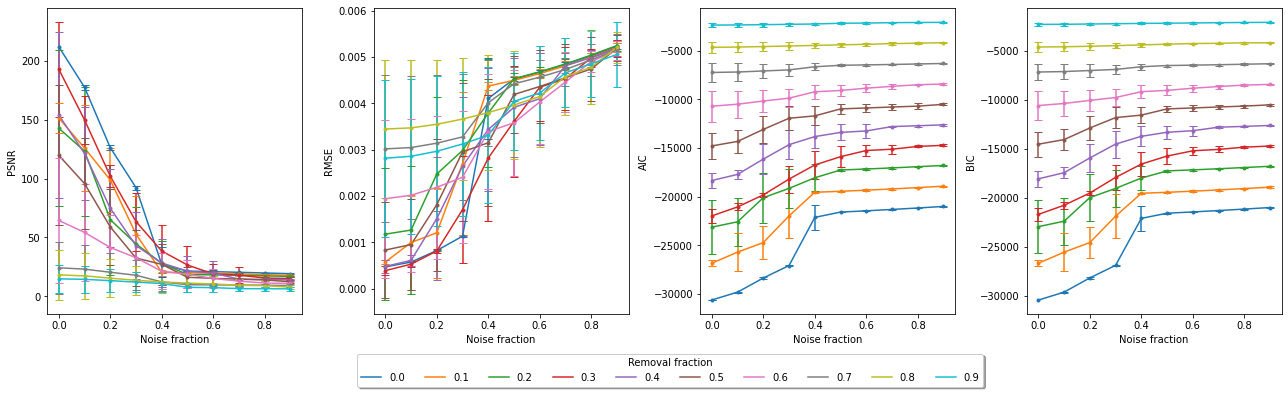

In [14]:
import os

if use_wavelet is None:
    ofile_name = "deltaf_basis_scenario_"+str(scenario)+".png"
else:
    ofile_name = "undecimated_csbasis_scenario_"+str(scenario)+".png"
fig, ax = plt.subplots(nrows=1, ncols=4, sharey='none', sharex='all', figsize=(18, 5))
cmap = plt.get_cmap('tab10')

for f in range(0, 4):
    number = means[f].shape[1]
    colors = [cmap(i) for i in np.linspace(0, 1, number)]

    for i, color in enumerate(colors, start=0):
        ax[f].plot(nsigma, means[f][:,i], label=str(nsigma[i]), color=color)
        ax[f].errorbar(nsigma, means[f][:,i], yerr = stds[f][:,i], fmt ='.', capsize=4, color=color)
        #ax[f].fill_between(nsigma, means[f][:,i]+stds[f][:,i], color=color, alpha=.5)
        #ax[f].fill_between(nsigma, means[f][:,i]-stds[f][:,i], color=color, alpha=.5)
        
    #if scenario == 1 and names[f] == "BIC":
    #    ax[f].legend(bbox_to_anchor=(1., 1.02), ncol=2, fancybox=True, shadow=True, title="Removal fraction")
    
    if scenario == 3:
        ax[f].set_xlabel("Noise fraction")
        
    ax[f].set_ylabel(names[f])
    
h, l = ax[0].get_legend_handles_labels()
if scenario ==3:
    legend = fig.legend(h, l, loc='lower center', ncol=10, fancybox=True, bbox_to_anchor=[0.52, -0.1], shadow=True, title="Removal fraction")
fig.tight_layout()
if os.path.isfile(ofile_name):
    os.remove(ofile_name)   # Opt.: os.system("rm "+strFile)
fig.savefig(ofile_name, dpi=100, bbox_inches='tight')

In [15]:
# [0.2, 0.5, 0.8] Removal fraction [2, 5, 8]
# [0.2, 0.5, 0.8] Noise # [2, 5, 8]
"""
for i in [2, 5, 8]:
    for j in [2, 5, 8]:
        idx = len(remove_frac)*i + j
        #print(idx)
        selected_test = test_objs[idx]
        print(np.max(selected_test.source.lambda2))
        plt.clf()
        plt.plot(selected_test.source.lambda2, selected_test.source.data.real, 'k.', label=r"Stokes $Q$")
        plt.plot(selected_test.source.lambda2, selected_test.source.data.imag, 'c.', label=r"Stokes $U$")
        plt.plot(selected_test.source.lambda2, np.abs(selected_test.source.data), 'g.', label=r"$|P|$")
        if i==8:
            plt.xlabel(r'$\lambda^2$[m$^{2}$]')
        else:
            plt.xticks([])
        if j==2:
            plt.ylabel(r'Jy/beam')
        else:
            plt.yticks([])
        #plt.legend(loc=(1.04, 0.755), fancybox=True, shadow=True)
        plt.xlim([0.0,0.09])
        plt.ylim([-0.01,0.01])
        plt.tight_layout()
        plt.savefig("pol_sim_rem_"+str(remove_frac[j])+"_noise_"+str(nsigma[i])+"_"+str(idx)+".png", dpi=100)
"""

'\nfor i in [2, 5, 8]:\n    for j in [2, 5, 8]:\n        idx = len(remove_frac)*i + j\n        #print(idx)\n        selected_test = test_objs[idx]\n        print(np.max(selected_test.source.lambda2))\n        plt.clf()\n        plt.plot(selected_test.source.lambda2, selected_test.source.data.real, \'k.\', label=r"Stokes $Q$")\n        plt.plot(selected_test.source.lambda2, selected_test.source.data.imag, \'c.\', label=r"Stokes $U$")\n        plt.plot(selected_test.source.lambda2, np.abs(selected_test.source.data), \'g.\', label=r"$|P|$")\n        if i==8:\n            plt.xlabel(r\'$\\lambda^2$[m$^{2}$]\')\n        else:\n            plt.xticks([])\n        if j==2:\n            plt.ylabel(r\'Jy/beam\')\n        else:\n            plt.yticks([])\n        #plt.legend(loc=(1.04, 0.755), fancybox=True, shadow=True)\n        plt.xlim([0.0,0.09])\n        plt.ylim([-0.01,0.01])\n        plt.tight_layout()\n        plt.savefig("pol_sim_rem_"+str(remove_frac[j])+"_noise_"+str(nsigma[i])+"_"+s